In [10]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
import clip
import os
import matplotlib.pyplot as plt


In [11]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"
print("Device:", device)
model, preprocess = clip.load("ViT-B/32", device=device)

Device: mps


In [12]:
transform = preprocess

robust_set = datasets.ImageFolder(root='data/stl10_robustness_set', transform=preprocess)

robust_loader = DataLoader(
    robust_set,
    batch_size=3,
    shuffle=False,
    num_workers=2
)

In [13]:
stl10_classes = [
    "airplane", "bird", "car", "cat", "deer",
    "dog", "horse", "monkey","ship", "truck"
]

all_text_features = []
for classname in stl10_classes:
    text = f"a {classname}"
    tokenized = clip.tokenize(text).to(device)
    text_features = model.encode_text(tokenized)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    class_feature = text_features.mean(dim=0)
    class_feature /= class_feature.norm()
    all_text_features.append(class_feature)
text_features = torch.stack(all_text_features, dim=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..1.9303361].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.398105..0.9493012].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


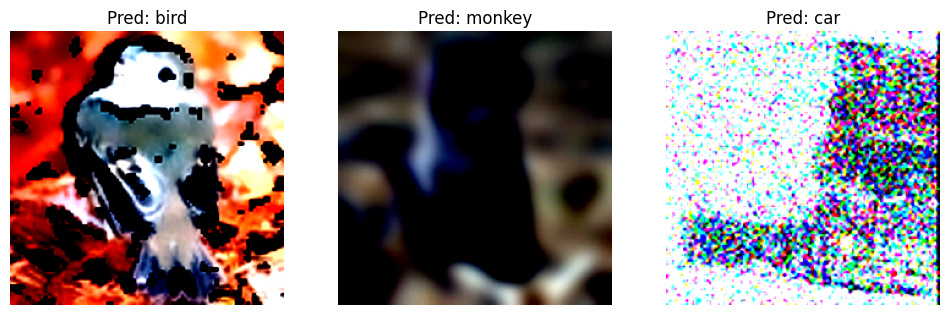

In [14]:
images, _ = next(iter(robust_loader))
images = images.to(device)

with torch.no_grad():
    image_features = model.encode_image(images)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    logits = image_features @ text_features.T
    preds = logits.argmax(dim=1).cpu().numpy()

plt.figure(figsize=(12, 4))
for i in range(len(preds)):
    plt.subplot(1, len(preds), i+1)
    img = images[i].cpu().permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Pred: {stl10_classes[preds[i]]}")
plt.show()